In [2]:
import os

import copy
"""
Assignment statements in Python do not copy objects!
they create bindings between a target and an object.
a copy is sometimes needed so one can change one copy without changing the other!
"""
from pathlib import Path

import scipy

import krotov

import numpy as np
import qutip
import matplotlib.pyplot as plt
#import colorsys
#from mpl_toolkits.mplot3d import Axes3D

import qdyn.model
import qdyn.pulse
# QDYN-pylib is a Python package for interacting with the Fortran QDYN library and tools
#!make clean

from multiprocessing import Pool

from qutip import tensor,qeye,ket

import subprocess as subp

In [3]:
%matplotlib widget

In [4]:
τ = 9
rf_p = "rf"+str(τ)

In [6]:

pul = qdyn.pulse.Pulse.read(rf_p + "/pulse1.oct.dat")
pul.plot()


FileNotFoundError: rf9/pulse1.oct.dat not found.

<font size="5"> Does the Optimized Pulse carry physical value?
    
1.) Load optimized pulse 
    


In [4]:
# Load optimized pulse

t1, pr1, pi1 = np.loadtxt(rf_p + "/pulse1.oct.dat", unpack=True)
#pul = qdyn.pulse.Pulse(t, amplitude=pr+1j*pi, time_unit="ns", ampl_unit="GHz")
#fig, ax = plt.subplots()
#pul.plot()
pul = qdyn.pulse.Pulse.read(rf_p + "/pulse1.oct.dat")


def get_more_time_points(L,p):
    # p = desired number of intermediate points between two adjacent points in L
    M = L.copy()
    M_min = M[0]
    M_max = M[-1]

    Empty = []
    for i in range(0,len(M)):
        Mi = M[i]
        if Mi == M_max:
            break
        else:
            Mi1 = M[i+1]
            
            intermediate_list = list(np.linspace(Mi,Mi1,p+2)) # +2 is start and final point of intermediate list, adjacent elements
            
            Empty = Empty + intermediate_list
            
            L_new = list(set(Empty))
            
            L_new = list(np.sort(L_new))
            
    #print(len(L_new))
        
    return L_new


#list(t) == get_more_points(list(t),0)



2.) Interpolate it  


In [5]:
# Do Interpolation

def interpolation_for_python(time_domain,number,k):
    # get runfolder with desired number
    rf_p = "rf" + str(number)
    
    tlist = list(time_domain)

    # unlike fortran, python needs a the starting point and the final point
    tlist.insert(0,0)
    tlist.append(number)
    
    # make k points between two adjacent time points
    time = get_more_time_points(tlist,k)

    pul = qdyn.pulse.Pulse.read(rf_p + "/pulse1.oct.dat")
    new_pulse_func = pul.as_func()

    interpolated_pulse = [new_pulse_func(t) for t in time]

    print('The number of time points are:')
    print(len(time))
    
    pulse_real = np.real(interpolated_pulse)

    return pulse_real,time


pulse_real,times = interpolation_for_python(time_domain = t1,number =  τ,k = 0)


The number of time points are:
902


3.) Recreate Dynamics

In [6]:
# Hamiltonian
def get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_real):
    
     
    Z = qutip.operators.sigmaz()
    X = qutip.operators.sigmax()
    E = qeye(2)
    
    X1X2 = tensor(X,X,E)
    X2X3 = tensor(E,X,X)
    Z1Z2 = tensor(Z,Z,E)
    
 
    k1 = 0.112358
    k2 = 0.222222
    k3 = 0.314159
    
    drift = -1/2 * ( ν1*tensor(Z,E,E) + ν2*tensor(E,Z,E) + ν3*tensor(E,E,Z) ) 
    coupl = k1*X1X2 + k2*Z1Z2 + k3*X2X3
    
    H0 = drift + coupl
    H0 = np.array(H0)  # important for dimensionality. Code recognizes the 8 x 
    
    Ham_0 = qutip.Qobj(H0) 
    
    H1 = tensor(X,E,E)
    H1 = np.array(H1)
    
    Ham_1 = qutip.Qobj(H1)

    
    return [Ham_0*(2*np.pi), [Ham_1,pulse*((2*np.pi)) ]]


# Define CANONICAL BASIS as LOGICAL BASIS

def logical_basis(dim):
    return [qutip.basis(dim,i) for i in range(0,dim)]

def projectors(logical_basis):
    return [qutip.ket2dm(k) for k in logical_basis]


# TARGET UNITARY GATE
Had = qutip.operations.hadamard_transform(N=1)
E = qeye(2)
Target = tensor(Had,E,E)
Target = np.array(Target)
target_gate = qutip.Qobj(Target)
    

logical_basis = logical_basis(dim=8)
projectors = projectors(logical_basis)


def do_propagate(objectives,t):
    opt_dynamics2 = [objectives[x].propagate(t, e_ops=None, propagator=krotov.propagators.expm)
        for x in [0, 1,2,3,4,5,6,7]]
    
    return [opt_dynamics2[i].states[-1] for i in range(0,8)]

# Load tlist from opt_result and propagate states with mesolve method
def do_mesolve(objectives,t):
    opt_dynamics = [objectives[x].mesolve(t, e_ops=None ) for x in [0, 1,2,3,4,5,6,7]]
    
    return [opt_dynamics[i].states[-1] for i in range(0,8)]


4.) Check Infidelity


In [7]:
def do_compare_infidelities(objectives,t):
    
    
    L2 = do_propagate(objectives,t)
    f2 = krotov.functionals.J_T_sm(L2,objectives)
    
    L3 = do_mesolve(objectives,t)
    f3 = krotov.functionals.J_T_sm(L3,objectives)
    
    #print(f2)

    print("Propagation final state infidelity: "+ str(f2))
    print("..........................................")


    print("Mesolve final state infidelity: " + str(f3))
    print("..........................................")


    
#do_compare_infidelities(objectives,time)

def meaningful_pulse_test(t1,τ):
    
    pulse_0, times0 = interpolation_for_python(time_domain = t1,number =  τ,k = 0)
    
    pulse_1, times1 = interpolation_for_python(time_domain = t1,number =  τ,k = 5)
    
    pulse_2, times2  = interpolation_for_python(time_domain = t1,number =  τ,k = 10)

    pulse_3, times3  = interpolation_for_python(time_domain = t1,number =  τ,k = 50)

    obj0 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_0) )

    obj1 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_1) )

    obj2 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_2) )

    obj3 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_3) )

    print('pulse_0 test')
    do_compare_infidelities(obj0,times0)

    print('pulse_1 test')
    do_compare_infidelities(obj1,times1)

    print('pulse_2 test')
    do_compare_infidelities(obj2,times2)

    print('pulse_3 test')
    do_compare_infidelities(obj3,times3)

    print('TEST END')
    



    
#meaningful_pulse_test(t1,τ)

The number of time points are:
9912


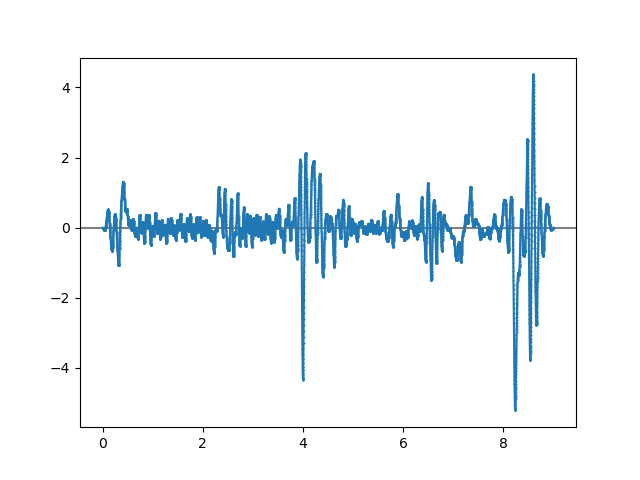

In [8]:


def linear_interpolation_for_python(time_domain,number,k):
    # get runfolder with desired number
    rf_p = "rf" + str(number)
    
    tlist = list(time_domain)

    # unlike fortran, python needs a the starting point and the final point
    tlist.insert(0,0)
    tlist.append(number)
    
    # make k points between two adjacent time points
    time = get_more_points(tlist,k)

    pul = qdyn.pulse.Pulse.read(rf_p + "/pulse1.oct.dat")
    
    new_pulse_func = pul.as_func()

    interpolated_pulse = [new_pulse_func(t) for t in time]

    print('The number of time points are:')
    print(len(time))
    
    pulse_real = np.real(interpolated_pulse)

    return pulse_real,time


def cubic_interpolation_for_python(number,k):
    # get runfolder with desired number
    rf_p = "rf" + str(number)
    
    t1, pr1, pi1 = np.loadtxt(rf_p + "/pulse1.oct.dat", unpack=True)
    
    tlist = list(t1)
    
    # unlike fortran, python needs a the starting point and the final point
    tlist = [0] + list(tlist) + [τ]
    
    #add bounds to pulse
    pulse_real1 = [0.] + list(pr1) + [0]

    # make k points between two adjacent time points
    new_times = get_more_time_points(tlist,k)

    #pul = qdyn.pulse.Pulse.read(rf_p + "/pulse1.oct.dat")
    #new_pulse_func = pul.as_func()
    #linear_interpolated_pulse = [new_pulse_func(t) for t in new_times]
    #real_linear_interpolated_pulse = np.real(linear_interpolated_pulse)

    cubic_interpolated_pulse = scipy.interpolate.interp1d(tlist, pulse_real1, kind="quadratic")

    new_pulse = cubic_interpolated_pulse(new_times)

    print('The number of time points are:')
    print(len(new_times))
    
    #pulse_real = np.real(interpolated_pulse)

    return new_pulse,new_times


new_pulse,times = cubic_interpolation_for_python(number =  τ,k = 10)

#times2 = np.linspace(times1[0], times1[-1], 5001)

fig,ax = plt.subplots()
ax.axhline(0,c="gray")
#ax.plot(t1, pr1, marker="x", ms=5)
#ax.plot(times1, pulse_real1, marker="s", ms=5)
#get new time grid
ax.plot(times, new_pulse, marker=".", ms=1)
#ax.plot(times1, new_pulse, marker=".", ms=5)

The number of time points are:
902
The number of time points are:
5407
The number of time points are:
9912
The number of time points are:
45952
pulse_0 test
Propagation final state infidelity: 0.006415555636130943
..........................................
Mesolve final state infidelity: 0.000865359715250813
..........................................
pulse_1 test
Propagation final state infidelity: 0.0009188771986299304
..........................................
Mesolve final state infidelity: 0.0008542378371184656
..........................................
pulse_2 test
Propagation final state infidelity: 0.0008672415132735534
..........................................
Mesolve final state infidelity: 0.0008633587765883854
..........................................
pulse_3 test
Propagation final state infidelity: 0.0008469628724442346
..........................................
Mesolve final state infidelity: 0.0008643214959357381
..........................................
TEST END


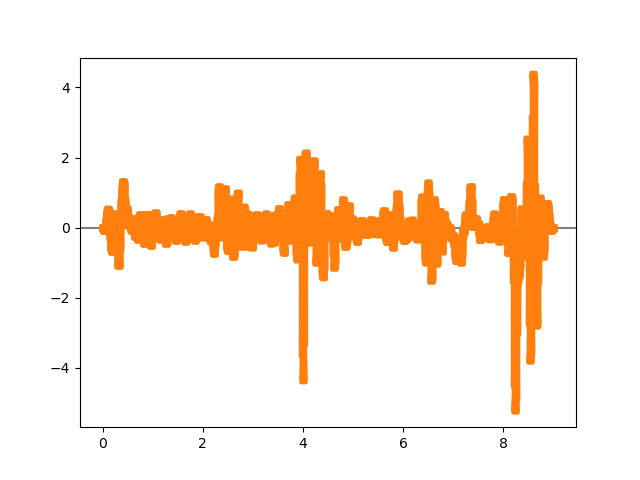

In [9]:
def cubic_meaningful_pulse_test(τ):
    
    pulse_0, times0 = cubic_interpolation_for_python(number =  τ,k = 0)
    
    pulse_1, times1 = cubic_interpolation_for_python(number =  τ,k = 5)
    
    pulse_2, times2  = cubic_interpolation_for_python(number =  τ,k = 10)

    pulse_3, times3  = cubic_interpolation_for_python(number =  τ,k = 50)

    fig,ax = plt.subplots()
    ax.axhline(0,c="gray")
    
    ax.plot(times0, pulse_0, marker="x", ms=5)
    ax.plot(times2, pulse_2, marker="s", ms=5)
#get new time grid
#ax.plot(times1, new_pulse, marker="o", ms=5)
#ax.plot(times1, new_pulse, marker=".", ms=5)

    obj0 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_0) )

    obj1 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_1) )

    obj2 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_2) )

    obj3 = krotov.gate_objectives( basis_states=logical_basis, gate = target_gate, H= get_Ham_pulse(ν1=5.0, ν2 = 5.3, ν3 = 5.5, T = τ,pulse = pulse_3) )

    print('pulse_0 test')
    do_compare_infidelities(obj0,times0)

    print('pulse_1 test')
    do_compare_infidelities(obj1,times1)

    print('pulse_2 test')
    do_compare_infidelities(obj2,times2)

    print('pulse_3 test')
    do_compare_infidelities(obj3,times3)

    print('TEST END')


cubic_meaningful_pulse_test(τ)

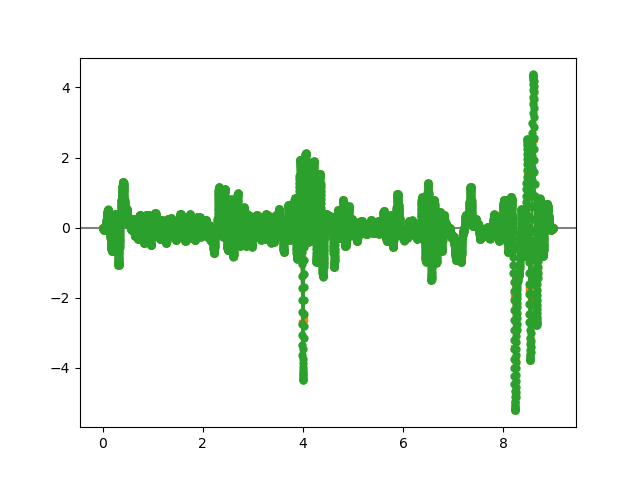

In [10]:
plt.close("all")
#load pulse
t1, pr1, pi1 = np.loadtxt(rf_p + "/pulse1.oct.dat", unpack=True)
pul = qdyn.pulse.Pulse(t1, amplitude=pr1, time_unit="ns", ampl_unit="GHz")

#add bounds to pulse
pulse_real1 = [0.] + list(pr1) + [0.]
times1 = [0] + list(t1) + [9.]

fig,ax = plt.subplots()
ax.axhline(0,c="gray")
ax.plot(t1, pr1, marker="x", ms=5)
ax.plot(times1, pulse_real1, marker="s", ms=5)
#get new time grid
times2 = np.linspace(times1[0], times1[-1], 5001)
#interpolate with scipy (cubic)
f = scipy.interpolate.interp1d(times1, pulse_real1, kind="cubic")

ax.plot(times2, f(times2), marker="o", ms=5)